# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [10]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")

db = client['Twitter']
All_Tweets_collection = db['twitter_mdp_ex_date_proj']


In [3]:
import pandas as pd
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)

# sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
#                                      allowDiskUse=True
#                                    )))

time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2019,5,1,0,0,0),
                                    '$lt': datetime.datetime(2020,8,1,0,0,0)},
            'retweeted_id': None
            })
        ))

In [4]:
sample_df = time_sample_df
type(sample_df.loc[:,('full_text')])
# sample_df.loc[:,('full_text')]
len(sample_df)

244471

##### Text Cleaning

In [6]:
# Load the regular expression library
pd.set_option('display.max_colwidth', 0)
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

sample_df = time_sample_df
# Remove punctuation
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text')].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))

# Remove Links
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('http.*', '', x))

sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('amp', '', x))

# Convert the titles to lowercase
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

sample_df = sample_df[sample_df['full_text_processed'] != '']
sample_df = sample_df[sample_df['full_text_processed'] != ' ']
sample_df = sample_df[sample_df['full_text_processed'] != '  ']

#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
sample_df['full_text_processed'].head(10)
len(sample_df)

242894

In [5]:
date = []
for timestamp in sample_df.created_at_datetime:
    date.append(timestamp.date())
      
sample_df.loc[:, ('date')] = date
sample_df.loc[:,('month')] = sample_df.created_at_datetime.dt.strftime('%y-%m')
sample_df.loc[:,('week')] = sample_df.created_at_datetime.dt.strftime('%y-w%U')

##### Durchsuche Datensatz nach bestimmten Tweets und sortiere aus

In [ ]:
# Print words that match certain words:
#sample_df['full_text_processed'][sample_df['full_text_processed'].str.match(r'.*brexit.*')==True]

# Remove Tweets that match certain words:
# sample_df = sample_df[~sample_df.full_text_processed.str.contains("fröhlicher gruss")]
# sample_df.groupby('user_party').size()

##### Stopwords

In [6]:
#from stop_words import get_stop_words
#stop_words = get_stop_words('de')

import stopwordsiso as stopwords
stop_words = list(stopwords.stopwords(["de"])) 

mehr_sw = ['der', 'die', 'das', 'Das', 'the', 'ist' 'es', 'gibt', 'und', 'für', 'auf', 'aus', 'mit', 'dem', 'tb', 'cducsubt', 'spdbt', 'fdpbt', 'sdpde']
for word in mehr_sw:
    stop_words.append(word)
    


# Sentiment Analyse - Wörterbuch
## Simple TextBlob Analysis

In [7]:
#import nltk
#nltk.download('punkt')
from textblob_de import TextBlobDE as TextBlob

blob = TextBlob(sample_df.full_text_processed[33504]) 

print(blob.sentences)
print(blob.tokens)
print(blob.tags)
print(blob.noun_phrases)
print(blob.sentiment)

[Sentence("jowadephul | ausweisung deutscher diplomaten aus russland nicht gerechtfertigt")]
['jowadephul', '|', 'ausweisung', 'deutscher', 'diplomaten', 'aus', 'russland', 'nicht', 'gerechtfertigt']
[('jowadephul', 'JJ'), ('|', 'NN'), ('ausweisung', 'NN'), ('deutscher', 'JJ'), ('diplomaten', 'NN'), ('aus', 'IN'), ('russland', 'NN'), ('nicht', 'RB'), ('gerechtfertigt', 'JJ')]
['jowadephul | ausweisung deutscher diplomaten']
Sentiment(polarity=-0.5, subjectivity=0.0)


#### Erstellen des DataFrame bzw. laden mit Pickle

In [8]:
# https://medium.com/@himanshu_23732/sentiment-analysis-with-textblob-6bc2eb9ec4ab
def sentiment(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None
    
sample_df['Polarity']     = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[0])
sample_df['Subjectivity'] = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[1])
sample_df.head()

,_id,created_at,id,full_text,is_quote_status,retweet_count,lang,created_at_datetime,user_id,user_name,...,user_friends_count,user_created_at,partei,user_party,full_text_processed,date,month,week,Polarity,Subjectivity
0,5e954d137973ce357347fb3a,Mon Apr 13 09:15:47 +0000 2020,1249627331947347968,Fordern wir schon lange! Endlich bewegen sich auch die #Altparteien! #AfDwirkt! https://t.co/9ulTPWxDM6 https://t.co/Wv2zNSQFqk,True,28,de,2020-04-13 09:15:47,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt,2020-04-13,20-04,20-w15,0.7,0.0
1,5e954d137973ce357347fb43,Sat Apr 11 15:29:32 +0000 2020,1248996612145283072,"Von wegen „Einthemenpartei“ #AfD: Hier eine kleine (!) Auswahl allein von dem,was ich (!) so angestoßen habe.Hinzukommen noch 88 weitere MdB-Kollegen &amp; zwei Dutzend Arbeitskreise!\nDie Karten gibt’s bei den Fraktionsveranstaltungen,z.B. #BiG.\n#AfDwirkt #Berlin #Bundestag #Brandner https://t.co/Q63XGjK3BM",False,84,de,2020-04-11 15:29:32,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,von wegen einthemenpartei afd hier eine kleine auswahl allein von demwas ich so angestoßen habehinzukommen noch 88 weitere mdb-kollegen zwei dutzend arbeitskreisedie karten gibt’s bei den fraktionsveranstaltungenzb bigafdwirkt berlin bundestag brandner,2020-04-11,20-04,20-w14,-0.7,0.0
2,5e954d137973ce357347fb4c,Sat Apr 11 06:24:16 +0000 2020,1248859393497731073,Leipzig: Mutter (37) stirbt nach Attacke auf sich und ihr Baby! https://t.co/DFo1njEfmF,False,10,de,2020-04-11 06:24:16,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,leipzig mutter 37 stirbt nach attacke auf sich und ihr baby,2020-04-11,20-04,20-w14,0.0,0.0
3,5e954d137973ce357347fb4e,Sat Apr 11 06:19:17 +0000 2020,1248858138058665985,Wie wir von der #AfD immer schon gesagt haben - und damit auch hier (wie immer👍) richtiglagen!\n#nurnochAfD #Klimahysterie #Klimaner https://t.co/FEXL8KtIrr,False,156,de,2020-04-11 06:19:17,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,wie wir von der afd immer schon gesagt haben - und damit auch hier wie immer👍 richtiglagennurnochafd klimahysterie klimaner,2020-04-11,20-04,20-w14,0.0,0.0
4,5e954d137973ce357347fb4f,Sat Apr 11 06:10:36 +0000 2020,1248855951119179782,Auch #Erfurt: An vielen Stellen in der Stadt entstehen neue - allerdings ziemlich kleine😉 - Grünflächen...👍 https://t.co/Z7MMf2klfG,False,3,de,2020-04-11 06:10:36,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,auch erfurt an vielen stellen in der stadt entstehen neue - allerdings ziemlich kleine😉 - grünflächen👍,2020-04-11,20-04,20-w14,0.0,1.0


In [1]:
import pickle, gensim, numpy as np
Path = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/'
#pickle.dump(sample_df, open(Path+'Sent_TextBlob_final.p', "wb" ))
sample_df = pickle.load(open(Path+'Sent_TextBlob_final.p', "rb" ))

#### Übersetzen von 'Polarity' in Categorie

In [2]:
# compute sentiment scores (polarity) and labels
sentiment_scores = sample_df['Polarity']
sample_df['category'] = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores]

## Darstellung von Ergebnissen

In [3]:
import pandas as pd
mdp_partei_TB = sample_df[['user_party', 'month', 'date', 'user_screen_name', 'full_text', 'category']]
#mdp_partei = mdp_partei.loc[(mdp_partei['predict'] == 'OFFENSE') & (mdp_partei['date'] >= datetime.date(2019,10,25))]
partei_piv_TB = pd.pivot_table(mdp_partei_TB, columns = ['category'], index = ['user_party'], aggfunc = np.count_nonzero)
partei_piv_TB['full_text']

category,negative,neutral,positive
user_party,,,
AFD,5927,13170,7778
FDP,7410,23321,16125
Gruene,5610,19511,14228
Linke,8448,19081,12662
SPD,5125,23480,18651
Union,4899,19397,15325


In [4]:
import datetime
from datetime import date
mdp_partei = sample_df[['user_party', 'month', 'week', 'date', 'user_screen_name', 'full_text', 'category']]

mdp_partei_nom = mdp_partei.loc[(mdp_partei['category'] == 'positive') & (mdp_partei['date'] >= datetime.date(2019,10,25))]
partei_piv_TB_nom = pd.pivot_table(mdp_partei_nom, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
partei_piv_TB_nom = partei_piv_TB_nom['date']

mdp_partei_denom = mdp_partei.loc[(mdp_partei['date'] >= datetime.date(2019,10,25))]
partei_piv_TB_denom = pd.pivot_table(mdp_partei_denom, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
partei_piv_TB_denom = partei_piv_TB_denom['date']

partei_piv_TB_rel = (partei_piv_TB_nom/partei_piv_TB_denom) * 100
partei_piv_TB_rel = partei_piv_TB_rel.round()

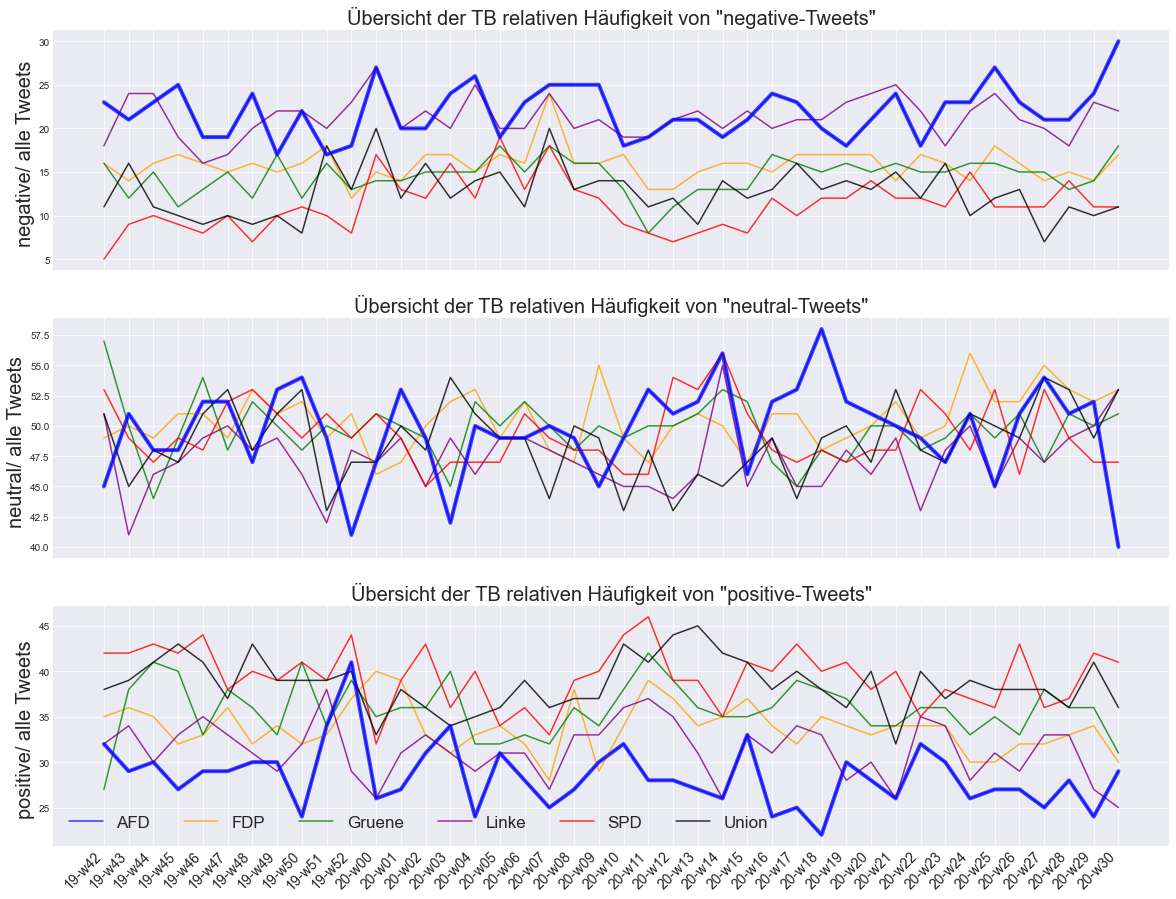

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

category = ['negative', 'neutral', 'positive']
mdp_partei = sample_df[['user_party', 'month', 'week', 'date', 'user_screen_name', 'full_text', 'category']]

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = plt.figure(figsize = (20, 15))

mdp_partei_denom = mdp_partei.loc[(mdp_partei['date'] >= datetime.date(2019,10,25))]
partei_piv_TB_denom = pd.pivot_table(mdp_partei_denom, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
partei_piv_TB_denom = partei_piv_TB_denom['date']

for cat, n in zip(category, range(1,len(category)+1)):
    mdp_partei_nom = mdp_partei.loc[(mdp_partei['category'] == cat) & (mdp_partei['date'] >= datetime.date(2019,10,25))]
    partei_piv_TB_nom = pd.pivot_table(mdp_partei_nom, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
    partei_piv_TB_nom = partei_piv_TB_nom['date']
    
    partei_piv_TB_rel = (partei_piv_TB_nom/partei_piv_TB_denom) * 100
    partei_piv_TB_rel = partei_piv_TB_rel.round()


###############  plot #################
    ax = fig.add_subplot(3,1,n)

    num=0
    for column in partei_piv_TB_rel:
        ax.plot(partei_piv_TB_rel.index, partei_piv_TB_rel[column], color = my_palette[num], alpha=0.8, label = column)
        num+=1

    ax.plot(partei_piv_TB_rel.index, partei_piv_TB_rel['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)

    ax.set_title('Übersicht der TB relativen Häufigkeit von "' + cat + '-Tweets"', size = 20)
    ylab = ax.set_ylabel(cat +'/ alle Tweets ', size = 20)
    if n <= 2:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        x_tags = plt.xticks(partei_piv_TB_rel.index, fontsize = 14, rotation = 45, ha = "right")
        plt.legend(loc = 3, ncol = 6, fontsize = 17)

## Basic Emotions
##### 1.) Erstellen der EmotionsMatrix

In dieser Matrix steht jede Zeile für ein deutsches Wort, welches den Wert 1 zugeschrieben bekommt, wenn eine der sieben "Basis Emotionen" damit verbunden ist.

In [7]:
%%time
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm


import csv
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 0)
    
######### Erstelle Emotions-Matrix

filepath = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Lexicon_based/german-emotion-dictionary/fundamental/'
emo_df = []
words = []
emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']
emotion_list= {}
stemmer = SnowballStemmer("german")

for emo in emotion:
    with open(filepath + emo + '.txt', newline='\n') as f:
        reader = csv.reader(f)
        data = [item for sublist in reader for item in sublist] 
        emotion_list[str(emo)] = data
        words.extend(data)
        
words = list(set(words)) # remove Duplicates which come from overlapping EmotionLists
emo_df  = pd.DataFrame(index=words, columns=emotion)

words = []
for word in emo_df.index:
    for emo in emo_df.columns:
        if word in emotion_list[emo]:
            emo_df.at[word, emo] = 1
        else:
            emo_df.at[word, emo] = 0
    words.append(stemmer.stem(word.lower()))
 
emo_df.index= words
emo_df = emo_df.sort_index(ascending=True)
emo_df = pd.DataFrame(emo_df)
emo_df = emo_df.loc[~emo_df.index.duplicated(keep='first')]

emo_df.head()


CPU times: user 806 ms, sys: 32.5 ms, total: 838 ms
Wall time: 928 ms


##### Check ob bestimmtes Wort in Matrix enthalten ist

In [10]:
emo_df.loc[emo_df.index == 'pfui']

,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut
pfui,1,0,0,0,0,1,0


In [14]:
from nltk.stem.cistem import Cistem
stemmer = Cistem()
# s1 = "Speicherbehältern"
# print("('" + stemmer.segment(s1)[0] + "', '" + stemmer.segment(s1)[1] + "')")
# s2 = "Grenzpostens"
stemmer.segment('Todesanzeige')

('todesanzeig', 'e')

#### 2.) Anwendung der Emotions Matrix auf den Twitter Datensatz
Jedes Wort in jedem Tweet wird in der Matrix gesucht und ggf. der Vektor zurückgegeben. 
Siehe Kommentare

In [16]:
%%time
emo_base_df = sample_df['full_text_processed']
df_emo = pd.DataFrame(0, index=emo_base_df.index, columns=emotion)

for i in emo_base_df.index:
    document = word_tokenize(emo_base_df.loc[i])
    for word in document:
        word = stemmer.stem(word.lower())             # Stemming des einzelnen Wortes aus Tweet um es...
        emo_score = emo_df[emo_df.index == word]      # ... mit den Lexikon Worten zu vergleichen -> emo_score 

        if not emo_score.empty:                       # der emo score eines Worts z.B. [0 0 1 1 0 0 0] 
            for emot in emotion:                      # wird zum Score des Tweets dazugezählt z.B.: [2 0 4 1 0 0 0]
                df_emo.at[i, emot] += emo_score[emot] # am Ende exisitiert zu einem Tweet ein 7-dim Vektor
                

emo_base_df = pd.concat([emo_base_df, df_emo], axis=1)

emo_base_df.head(20)

CPU times: user 43min 46s, sys: 2.8 s, total: 43min 48s
Wall time: 43min 42s


,full_text_processed,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut
0,fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt,0,1,0,0,0,0,0
1,von wegen einthemenpartei afd hier eine kleine auswahl allein von demwas ich so angestoßen habehinzukommen noch 88 weitere mdb-kollegen zwei dutzend arbeitskreisedie karten gibt’s bei den fraktionsveranstaltungenzb bigafdwirkt berlin bundestag brandner,0,0,0,0,0,0,0
2,leipzig mutter 37 stirbt nach attacke auf sich und ihr baby,0,1,1,0,0,0,1
3,wie wir von der afd immer schon gesagt haben - und damit auch hier wie immer👍 richtiglagennurnochafd klimahysterie klimaner,0,1,0,0,0,0,0
4,auch erfurt an vielen stellen in der stadt entstehen neue - allerdings ziemlich kleine😉 - grünflächen👍,0,0,0,0,1,0,0
5,lindner lamentiert mal wieder🥱umfallerpartei,0,0,0,0,0,0,0
6,huch🤭grenzschliessung grenzkontrollen,0,0,0,0,0,0,0
7,heimweg am gründonnerstagich wünsche ein frohes besinnliches ruhiges und vor allem gesundes osterfestostern,0,1,0,0,0,0,0
8,nein,0,0,0,0,0,0,0
9,afdwirkt endlich kommen die altparteien auch hier zur vernunft,0,0,0,0,0,0,0


###### Füge 'id' hinzu um später den Vergleich mit anderen SentAn Methoden zu erleichtern

In [18]:
emo_sample_df = pd.concat([emo_base_df,sample_df['id']], axis = 1)
emo_sample_df.columns

Index(['full_text_processed', 'Ekel', 'Freude', 'Furcht', 'Trauer',
       'Ueberraschung', 'Verachtung', 'Wut', 'id'],
      dtype='object')

## Load/ Dump einfache Matrix (nicht relativ, aber mit id)

In [15]:
import pickle, gensim, numpy as np
#pickle.dump(emo_sample_df, open(Path + 'Sent_BE_abs.p', "wb" ))
sent_basic_emo = pickle.load(open(Path + 'Sent_BE_abs.p', "rb" ))
sent_basic_emo.head(5)

,full_text_processed,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,id
0,fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt,0,1,0,0,0,0,0,1249627331947347968
1,von wegen einthemenpartei afd hier eine kleine auswahl allein von demwas ich so angestoßen habehinzukommen noch 88 weitere mdb-kollegen zwei dutzend arbeitskreisedie karten gibt’s bei den fraktionsveranstaltungenzb bigafdwirkt berlin bundestag brandner,0,0,0,0,0,0,0,1248996612145283072
2,leipzig mutter 37 stirbt nach attacke auf sich und ihr baby,0,1,1,0,0,0,1,1248859393497731073
3,wie wir von der afd immer schon gesagt haben - und damit auch hier wie immer👍 richtiglagennurnochafd klimahysterie klimaner,0,1,0,0,0,0,0,1248858138058665985
4,auch erfurt an vielen stellen in der stadt entstehen neue - allerdings ziemlich kleine😉 - grünflächen👍,0,0,0,0,1,0,0,1248855951119179782


##### Bearbeite Columns um Darstellung später zu erleichtern

In [16]:
#### Add Timestamp
sent_basic_emo = sent_basic_emo[['full_text_processed', 'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut', 'id']]
sent_basic_emo[['user_party', 'month', 'week', 'date', 'user_screen_name']] = sample_df [['user_party', 'month', 'week', 'date', 'user_screen_name']]

sent_basic_emo.head(1)

,full_text_processed,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,id,user_party,month,week,date,user_screen_name
0,fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt,0,1,0,0,0,0,0,1249627331947347968,AFD,20-04,20-w15,2020-04-13,StBrandner


##### Begrenze die Auswahl von relevanten Tweets -> emo_base_select

In [18]:
emo_base_select = sent_basic_emo
# emo_base_select = emo_base_df[emo_base_df['full_text_processed'].str.match(r'.*((?i)corona|(?i)Covid).*')==True]
# len(emo_base_select[emo_base_select['Partei']=='Gruene'])
# len(emo_base_select)

####  3.) Remove empty full_text_processed
Wenn z.B. nur ein Link und emojis gepostet wurden ist nach dem text cleaning die Zelle leer (aber nicht isnull() == true)

In [19]:
emo_base_text = sent_basic_emo.drop(sent_basic_emo[sent_basic_emo['full_text_processed']==''].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']==' '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='  '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='   '].index)

In [20]:
emo_party = emo_base_text.groupby('user_party').sum()
emo_party.head()

,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,id
user_party,,,,,,,,
AFD,500.0,6519.0,2779.0,2917.0,2376.0,6381.0,1435.0,3.217173e+22
FDP,744.0,10719.0,3152.0,4797.0,4203.0,7200.0,1434.0,5.659159e+22
Gruene,570.0,11518.0,2957.0,3922.0,3799.0,5251.0,1563.0,4.747904e+22
Linke,728.0,9519.0,4355.0,4908.0,3399.0,8511.0,1834.0,4.828617e+22
SPD,693.0,17031.0,3132.0,4181.0,3794.0,5517.0,1386.0,5.707358e+22


#### 4.) Relativieren von Werten
1.) Teile durch Länge (Wordcount) des Tweets => emo_base_rel

In [ ]:
from nltk import tokenize
from nltk import word_tokenize
emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']

emo_base_rel=emo_base_text

emo_base_rel['word_count'] = emo_base_rel['full_text_processed'].apply(tokenize.word_tokenize).apply(len)

for emo in emotion:
    emo_base_rel[emo] = emo_base_rel[emo] / emo_base_rel['word_count']
emo_base_rel.head(5)

2.) Teile durch die Menge der Tweets pro Partei => emo_party_rel
## wichtig: Teile erst durch Anzahl an Tweets wenn Topic bestimmt wurde!
## Hier: Partei
#### " Relativiere durch Anzahl von Tweets pro Partei"

In [28]:
# 2.) Teilen durch Gesammtzahl an Tweets pro Partei #### umständliche aber korrekte Version
emo_party_sum = emo_base_rel.groupby('user_party').sum()
emo_party_count = emo_base_rel.groupby('user_party').count()
emo_party_rel = emo_party_sum/ emo_party_count
emo_party_rel

,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,date,full_text_processed,id,month,user_screen_name,week,word_count
user_party,,,,,,,,,,,,,,
AFD,0.000829,0.012687,0.004308,0.004847,0.004284,0.010764,0.002246,NaN,NaN,1.212792e+18,NaN,NaN,NaN,22.204546
FDP,0.000652,0.012725,0.002702,0.004684,0.003937,0.007324,0.001259,NaN,NaN,1.213552e+18,NaN,NaN,NaN,21.873030
Gruene,0.000696,0.018901,0.003012,0.004589,0.004599,0.006458,0.001634,NaN,NaN,1.210737e+18,NaN,NaN,NaN,21.801505
Linke,0.000762,0.012348,0.004032,0.004962,0.003766,0.009535,0.001745,NaN,NaN,1.212855e+18,NaN,NaN,NaN,24.146740
SPD,0.000708,0.025542,0.002451,0.003980,0.003870,0.005977,0.001166,NaN,NaN,1.212964e+18,NaN,NaN,NaN,20.650224
Union,0.000588,0.019315,0.002283,0.003707,0.004358,0.006790,0.001325,NaN,NaN,1.209848e+18,NaN,NaN,NaN,21.615205


In [7]:
import pickle, gensim, numpy as np
#pickle.dump(emo_base_rel, open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_BE_rel_final.p', "wb" ))
emo_base_rel = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_BE_rel_final.p', "rb" ))
emo_base_rel.head(4)

,full_text_processed,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,id,user_party,month,week,date,user_screen_name,word_count
0,fordern wir schon lange endlich bewegen sich a...,0.0,0.090909,0.000000,0.0,0.0,0.0,0.000000,1249627331947347968,AFD,20-04,20-w15,2020-04-13,StBrandner,11
1,von wegen einthemenpartei afd hier eine kleine...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,1248996612145283072,AFD,20-04,20-w14,2020-04-11,StBrandner,33
2,leipzig mutter 37 stirbt nach attacke auf sich...,0.0,0.090909,0.090909,0.0,0.0,0.0,0.090909,1248859393497731073,AFD,20-04,20-w14,2020-04-11,StBrandner,11
3,wie wir von der afd immer schon gesagt haben -...,0.0,0.052632,0.000000,0.0,0.0,0.0,0.000000,1248858138058665985,AFD,20-04,20-w14,2020-04-11,StBrandner,19


## Darstellung von Ergebnissen nach Zeitabschnitten

In [40]:
import pandas as pd
mdp_partei_emo = emo_base_rel[['user_party', 'month', 'week', 'date', 'user_screen_name', 'full_text_processed',
                              'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]
partei_piv_emo = pd.pivot_table(mdp_partei_emo, columns = ['user_party'], index = ['month'], aggfunc = np.count_nonzero)

emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']

partei_piv_emo_rel = partei_piv_emo[['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]
partei_piv_emo_denom = partei_piv_emo['user_screen_name']

for emo in emotion:
    partei_piv_emo_rel[emo] = partei_piv_emo[emo]#/partei_piv_emo_denom

# partei_piv_emo_rel

/usr/local/anaconda3/bin/ipython:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


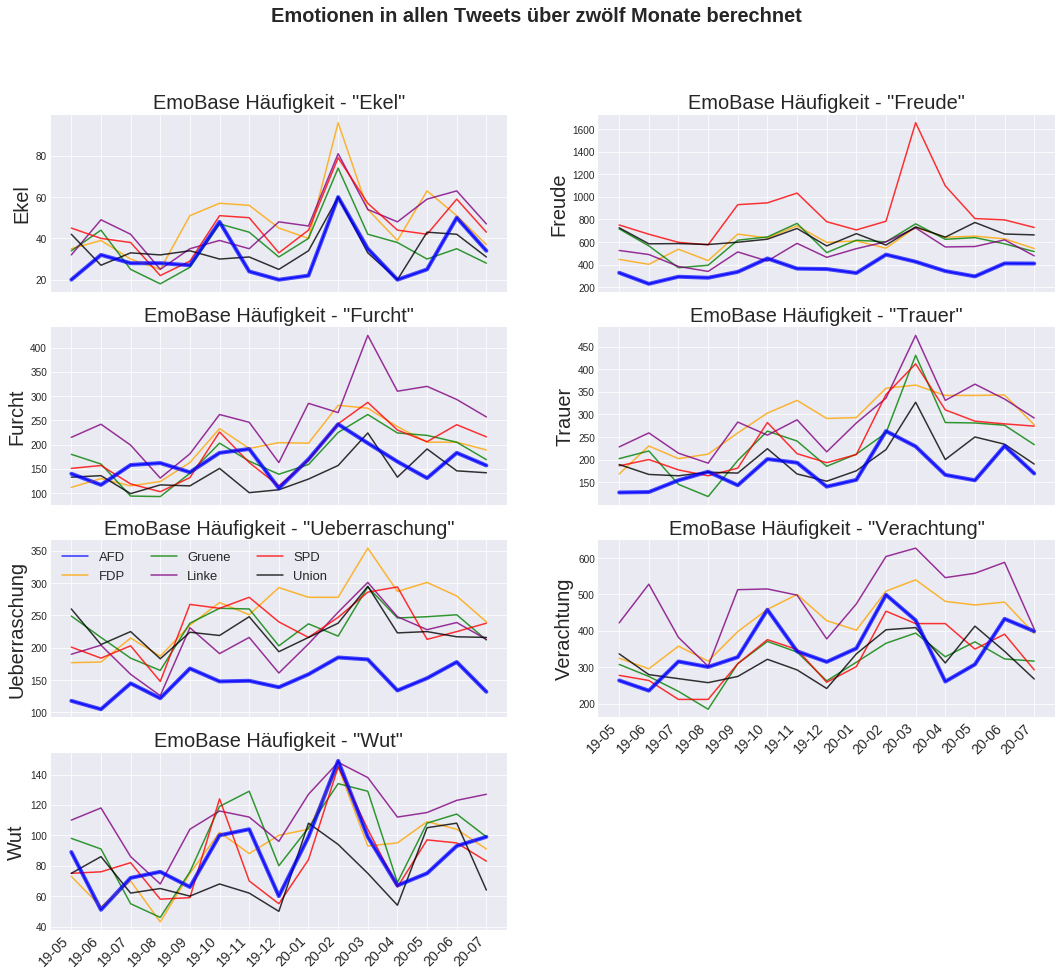

In [43]:
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
fig = plt.figure(figsize = (18, 15))
fig.tight_layout()
fig.suptitle('Emotionen in allen Tweets über zwölf Monate berechnet', fontsize = 20, weight = 'bold')

for emo, n in zip(emotion, range(1,len(emotion)+1)):
    ax = fig.add_subplot(4,2,n)
    
    num=0
    for column in partei_piv_emo_rel[emo]:
        ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo][column], color = my_palette[num], alpha=0.8, label = column)
        num+=1
    ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo]['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)
    ax.set_title('EmoBase rel Häufigkeit - "' +emo+ '"', size = 20)
    ylab = ax.set_ylabel(emo +' / alle ', size = 20)
    #plt.ylim((0,0.35))
    
    if n <= 5:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        x_tags = plt.xticks(partei_piv_emo_rel.index, fontsize = 14, rotation = 45, ha = "right")
    if n == 5:
        plt.legend(loc = 1, ncol = 3, fontsize = 13)



In [290]:
partei_piv_emo['user_screen_name']

user_party,AFD,FDP,Gruene,Linke,SPD,Union
month,,,,,,
19-05,59,77,337,104,100,90
19-06,74,111,191,202,88,112
19-07,102,186,191,61,90,85
19-08,96,89,167,62,88,47
19-09,177,325,391,263,239,177
19-10,107,132,222,116,144,82
19-11,73,118,221,126,123,69
19-12,110,214,164,122,133,77
20-01,102,93,170,84,58,65


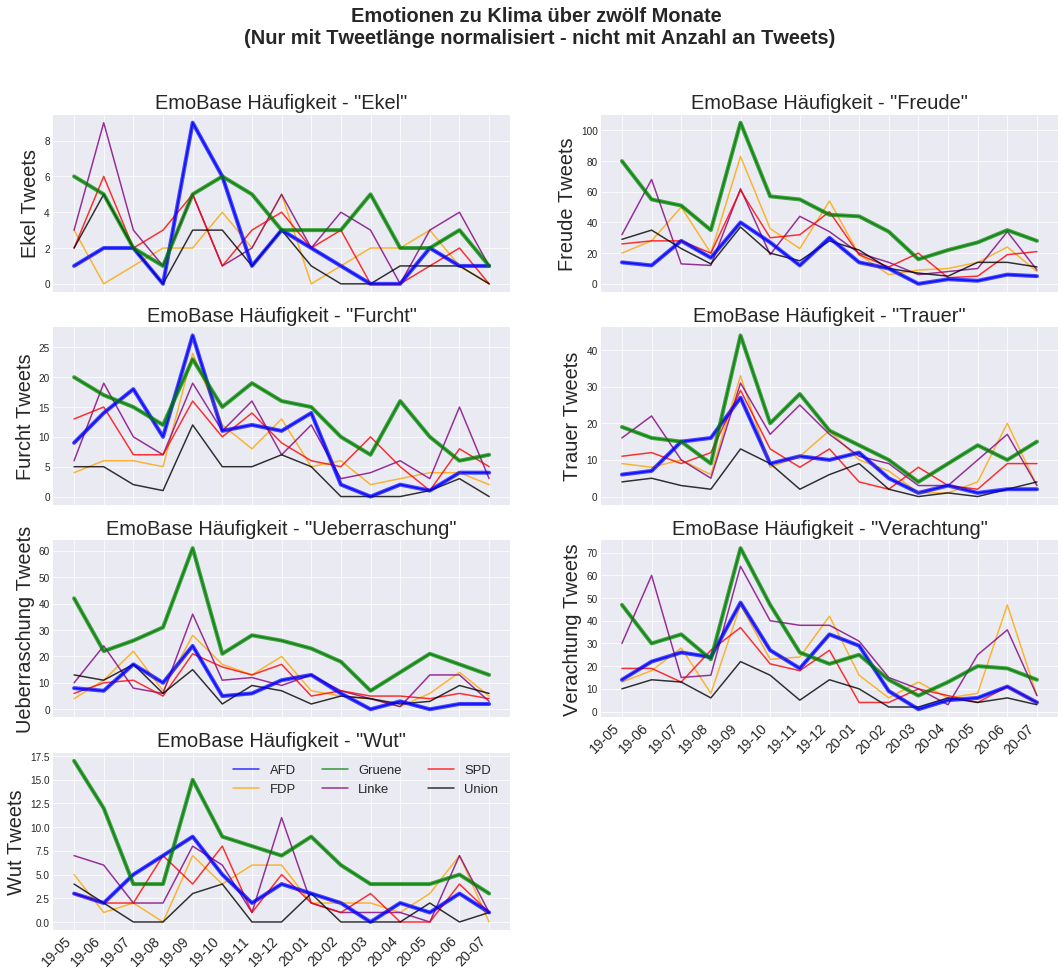

In [37]:
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

Topic = 'Klima'

mdp_partei_emo = emo_base_rel[['user_party', 'month', 'week', 'date', 'user_screen_name', 'full_text_processed',
                              'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]

sent_Merkel = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Merkel.*)(?i)')==True]
sent_Mig = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Migration.*|.*Migrant.*|.*Flücht.*|.*Asyl.*)(?i)')==True]
sent_Klima = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Klima.*|.*Greta.*|.*Friday.*)(?i)')==True]
sent_GEZ = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*ARD.*|.*ZDF.*|.*WDR.*|.*GEZ.*|.*ÖRR.*|.*Rundfunk.*|.*Staatsfunk.*)(?i)')==True]
sent_Corona = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Corona.*|.*Covid.*|.*Sars.*)(?i)')==True]
sent_ALU = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Verschwö.*|.*Aluhut.*|.*Hildmann.*|.*Impfpflicht.*|.*Widerstand2020.*|.*Hygienedemos.*|.*Fake News*|.*FakeNews.*)(?i)')==True]
sent_Islam = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Islam.*|.*Moslem.*|.*Muslim.*|.*Kopftuch.*|.*Koran.*|.*Mosche.*|.*Arab.*|.*Imam.*)(?i)')==True]
sent_LiEx = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Linksextrem.*)(?i)')==True]
sent_ReEx = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Rechtsextrem.*)(?i)')==True]

Topics = {}
#[sent_LiEx, sent_ReEx]
Topics['Merkel'] = sent_Merkel
Topics['Migration'] = sent_Mig
Topics['Klima'] = sent_Klima
Topics['ÖRR'] = sent_GEZ
Topics['Corona'] = sent_Corona
Topics['Verschwörungs Geschichten'] = sent_ALU
Topics['Islam'] = sent_Islam
Topics['Linksexremismus'] = sent_LiEx
Topics['Rechtsextremismus'] = sent_ReEx

partei_piv_emo = pd.pivot_table(Topics[Topic], columns = ['user_party'], index = ['month'], aggfunc = np.count_nonzero)


emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']
partei_piv_emo_rel = partei_piv_emo[emotion]

################ plot ##################

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
fig = plt.figure(figsize = (18, 15))
fig.tight_layout()
fig.suptitle('Emotionen zu ' + Topic +' über zwölf Monate \n(Nur mit Tweetlänge normalisiert - nicht mit Anzahl an Tweets)', fontsize = 20, weight = 'bold')


for emo, n in zip(emotion, range(1,len(emotion)+1)):
    ax = fig.add_subplot(4,2,n)
    
    num=0
    for column in partei_piv_emo_rel[emo]:
        ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo][column], color = my_palette[num], alpha=0.8, label = column)
        num+=1
    ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo]['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)
    ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo]['Gruene'], marker='', color='green', linewidth=4, alpha=0.7)
    ax.set_title('EmoBase Häufigkeit - "' +emo+ '"', size = 20)
    ylab = ax.set_ylabel(emo +' Tweets', size = 20)
    
    if n <= 5:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        x_tags = plt.xticks(partei_piv_emo_rel.index, fontsize = 14, rotation = 45, ha = "right")
    if n == 7:
        plt.legend(loc = 1, ncol = 3, fontsize = 13)

/usr/local/anaconda3/bin/ipython:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


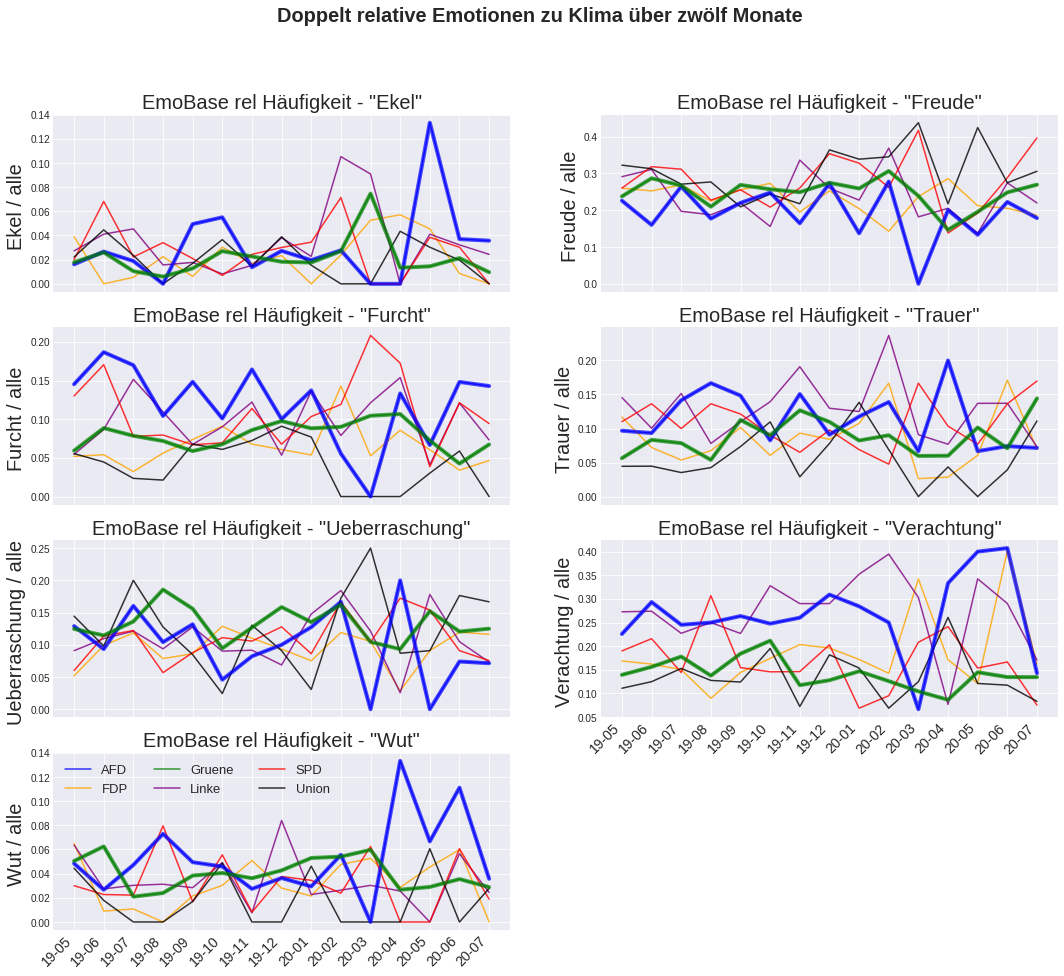

In [38]:
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np


Topic = 'Klima'

mdp_partei_emo = emo_base_rel[['user_party', 'month', 'week', 'date', 'user_screen_name', 'full_text_processed',
                              'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]

sent_Merkel = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Merkel.*)(?i)')==True]
sent_Mig = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Migration.*|.*Migrant.*|.*Flücht.*|.*Asyl.*)(?i)')==True]
sent_Klima = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Klima.*|.*Greta.*|.*Friday.*)(?i)')==True]
sent_GEZ = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*ARD.*|.*ZDF.*|.*WDR.*|.*GEZ.*|.*ÖRR.*|.*Rundfunk.*|.*Staatsfunk.*)(?i)')==True]
sent_Corona = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Corona.*|.*Covid.*|.*Sars.*)(?i)')==True]
sent_ALU = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Verschwö.*|.*Aluhut.*|.*Hildmann.*|.*Impfpflicht.*|.*Widerstand2020.*|.*Hygienedemos.*|.*Fake News*|.*FakeNews.*)(?i)')==True]
sent_Islam = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Islam.*|.*Moslem.*|.*Muslim.*|.*Kopftuch.*|.*Koran.*|.*Mosche.*|.*Arab.*|.*Imam.*)(?i)')==True]
sent_LiEx = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Linksextrem.*)(?i)')==True]
sent_ReEx = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*Rechtsextrem.*)(?i)')==True]

Topics = {}
#[sent_LiEx, sent_ReEx]
Topics['Merkel'] = sent_Merkel
Topics['Migration'] = sent_Mig
Topics['Klima'] = sent_Klima
Topics['ÖRR'] = sent_GEZ
Topics['Corona'] = sent_Corona
Topics['Verschwörungs Geschichten'] = sent_ALU
Topics['Islam'] = sent_Islam
Topics['Linksexremismus'] = sent_LiEx
Topics['Rechtsextremismus'] = sent_ReEx

partei_piv_emo = pd.pivot_table(Topics[Topic], columns = ['user_party'], index = ['month'], aggfunc = np.count_nonzero)


emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']
partei_piv_emo_rel = partei_piv_emo[emotion]
partei_piv_emo_denom = partei_piv_emo['user_screen_name']

for emo in emotion:
    partei_piv_emo_rel[emo] = partei_piv_emo[emo]/partei_piv_emo_denom

################ plot ##################

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
fig = plt.figure(figsize = (18, 15))
fig.tight_layout()
fig.suptitle('Doppelt relative Emotionen zu ' + Topic +' über zwölf Monate', fontsize = 20, weight = 'bold')

for emo, n in zip(emotion, range(1,len(emotion)+1)):
    ax = fig.add_subplot(4,2,n)
    
    num=0
    for column in partei_piv_emo_rel[emo]:
        ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo][column], color = my_palette[num], alpha=0.8, label = column)
        num+=1
    ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo]['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)
    ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo]['Gruene'], marker='', color='green', linewidth=4, alpha=0.7)

    ax.set_title('EmoBase rel Häufigkeit - "' +emo+ '"', size = 20)
    
    ylab = ax.set_ylabel(emo +' / alle ', size = 20)
    
    if n <= 5:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        x_tags = plt.xticks(partei_piv_emo_rel.index, fontsize = 14, rotation = 45, ha = "right")
    if n == 7:
        plt.legend(loc = 2, ncol = 3, fontsize = 13)

/usr/local/anaconda3/bin/ipython:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


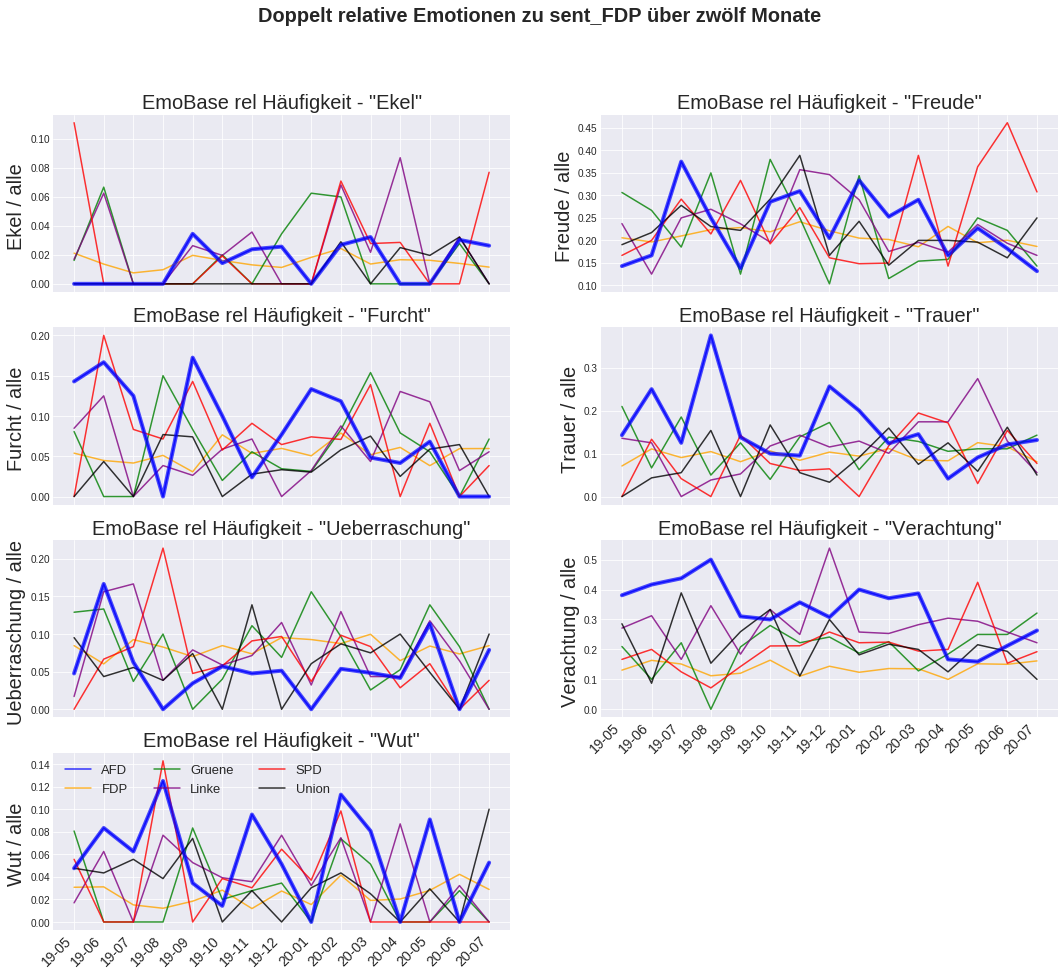

In [38]:
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np


Topic = 'sent_FDP'
# Tweet_Partei = 'Gruene'

mdp_partei_emo = emo_base_rel[['user_party', 'month', 'week', 'date', 'user_screen_name', 'full_text_processed',
                              'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]
#mdp_partei_emo = mdp_partei_emo.loc[mdp_partei_emo['user_party'] == Tweet_Partei]

sent_AFD = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*afd.*)(?i)')==True]
sent_Union = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*cdu.*|.*csu.*|.*union.*)(?i)')==True]
sent_FDP = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*fdp.*)(?i)')==True]
sent_Linke = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*linke.*)(?i)')==True]
sent_SPD = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*spd.*)(?i)')==True]
sent_Gruene = mdp_partei_emo[mdp_partei_emo['full_text_processed'].str.match(r'(.*gruene.*)(?i)')==True]

Topics = {}
#[sent_LiEx, sent_ReEx]
Topics['sent_AFD'] = sent_AFD
Topics['sent_Union'] = sent_Union
Topics['sent_FDP'] = sent_FDP
Topics['sent_Linke'] = sent_Linke
Topics['sent_SPD'] = sent_SPD
Topics['sent_Gruene'] = sent_Gruene

partei_piv_emo = pd.pivot_table(Topics[Topic], columns = ['user_party'], index = ['month'], aggfunc = np.count_nonzero)


emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']
partei_piv_emo_rel = partei_piv_emo[emotion]
partei_piv_emo_denom = partei_piv_emo['user_screen_name']

for emo in emotion:
    partei_piv_emo_rel[emo] = partei_piv_emo[emo]/partei_piv_emo_denom

################ plot ##################

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
fig = plt.figure(figsize = (18, 15))
fig.tight_layout()
fig.suptitle('Doppelt relative Emotionen zu ' + Topic +' über zwölf Monate', fontsize = 20, weight = 'bold')

for emo, n in zip(emotion, range(1,len(emotion)+1)):
    ax = fig.add_subplot(4,2,n)
    
    num=0
    for column in partei_piv_emo_rel[emo]:
        ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo][column], color = my_palette[num], alpha=0.8, label = column)
        num+=1
    ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo]['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)
    ax.set_title('EmoBase rel Häufigkeit - "' +emo+ '"', size = 20)
    ylab = ax.set_ylabel(emo +' / alle ', size = 20)
    
    if n <= 5:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        x_tags = plt.xticks(partei_piv_emo_rel.index, fontsize = 14, rotation = 45, ha = "right")
    if n == 7:
        plt.legend(loc = 2, ncol = 3, fontsize = 13)

# Vergleich der Label von konkreten Tweets
##### Laden der DataFrames

In [1]:
import pandas as pd
import datetime
import pickle, gensim, numpy as np

sent_df_Wien = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/sent_df_Wien_final.p', "rb" ))
sent_df_TB = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_TextBlob', "rb" ))
sent_basic_emo = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/sent_basic_emo', "rb" ))

##### Zusammenfügen der Data Frames Wien, TB, und Basic Emo

In [15]:
pd.set_option('display.max_rows', None)

compare = sent_df_TB.join(sent_df_Wien.set_index('id'), on='id', rsuffix='Wien', how = 'outer')
compare.columns
compare_df = compare[['id','date','full_text_processed', 'user_screen_name', 'user_party', 'predict', 'Polarity', 'Subjectivity']]

compare2 = compare_df.join(sent_basic_emo.set_index('id'), on='id', rsuffix='emo', how = 'outer')
compare2.columns
compare2_df = compare2[['date','full_text_processed', 'user_screen_name', 'user_party', 'predict', 'Polarity', 
                        'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]

compare2_df = compare2_df.dropna()
len(compare2_df)

196215

In [77]:
emo_df.loc[emo_df.index == 'hass']

,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut
hass,0,0,0,0,0,0,1


In [11]:
from nltk.stem.cistem import Cistem
stemmer = Cistem()
# s1 = "Speicherbehältern"
# print("('" + stemmer.segment(s1)[0] + "', '" + stemmer.segment(s1)[1] + "')")
# s2 = "Grenzpostens"
stemmer.segment('stirbt')

('stirb', 't')

In [17]:
compare2_df.columns = (['date', 'full_text_processed', 'User', 'Partei', 'predict', 'Polarity', 'Eke', 'Fre', 'Fur', 'Tra', 'Übe', 'Ver', 'Wut'])

In [20]:
pd.set_option('display.max_colwidth', 0)
compare2_df.loc[(compare2_df['Wut'] >= 1)&
               (compare2_df['Partei'] == 'AFD')].head(30)
# compare2_df.loc[compare2_df['predict'] == 'OFFENSE'].head(30)
# sent_ReEx.loc[(sent_ReEx['date'] >= datetime.date(2020,3,8))
# compare2_df.head(4)

compare2_df.tail()

,date,full_text_processed,User,Partei,predict,Polarity,Eke,Fre,Fur,Tra,Übe,Ver,Wut
206873.0,2020-03-18,die coronakrise betrifft uns alle die zustände in den überfüllten flüchtlingslagern sind ohne die gefahren der pandemie schon untragbar in diesen zeiten ist ein schnelles handeln umso dringender bitte unterstützt die kagne leavenoonebehind,Ingrid_Nestle,Gruene,OTHER,0.233333,0.0,0.0,1.0,1.0,2.0,1.0,0.0
206874.0,2020-03-18,solidarität statt egoismus heißt in zeiten von coronavirusdeutschland genau das,Ingrid_Nestle,Gruene,OTHER,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206875.0,2020-03-17,die regierung in schleswig-holstein informiert aktuell über die coronakrise informiert euch bitte über offizielle kanäle lasst uns solidarisch und besonnen bleiben,Ingrid_Nestle,Gruene,OTHER,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
206876.0,2020-03-17,herzlichen glückwunsch an gruene_bayern für einen starken wahlkf und ein tolles ergebnis nicht nur in den städten sondern auch im ländlichen raum konnten grüne themen und kandidat*innen überzeugen kommunalwahl2020 bayern,Ingrid_Nestle,Gruene,OTHER,1.000000,0.0,3.0,0.0,0.0,1.0,0.0,0.0
206877.0,2019-06-11,vor dem kanzleramt protestieren klimaaktivist*innen völlig zurecht machen sie sich sorgen um unser aller zukunft über die klimakrise wird viel geredet wir müssen aber handeln,Ingrid_Nestle,Gruene,OTHER,0.350000,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [50]:
import random
dic_comp = {}
Parteien = ['Gruene', 'Linke']

for partei in Parteien:
    df = compare2_df.loc[(compare2_df['Partei'] == partei)]
    sample = random.sample(list(df.index), 5)
    dic_comp[partei] = df.loc[sample]
    
df_comp = pd.concat(dic_comp, axis=0)
df_comp.index = df_comp.index.get_level_values(1)
df_comp

,date,full_text_processed,User,Partei,predict,Polarity,Eke,Fre,Fur,Tra,Übe,Ver,Wut
174654.0,2020-02-01,herzlichen glückwunsch an amica zum diesjährigen göttinger friedenspreis,JTrittin,Gruene,OTHER,1.000000,0.0,2.0,0.0,0.0,0.0,0.0,0.0
20243.0,2019-08-06,dass schwere suvs als plug-in-hybride mit e-kennzeichen herumfahren ist reiner etikettenschwindel mit mini-elektrischen reichweiten ist der umweltvorteil in praxis kaum vorhanden bringen elektromobilität in misskredit kaufprämie nicht gerechtfertigt,stephankuehn,Gruene,OTHER,-0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183789.0,2019-10-15,die bundesregierung muss tunesien jetzt ausreichend unterstützung zur verfügung stellen sein noch junges demokratisches system weiter zu stabilisieren auf keinen fall dürfen reformen zu einem rückfall in autoritäre verhältnisse führen wahl,nouripour,Gruene,OTHER,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203488.0,2020-05-06,wirr widerlich antidemokratisch,DJanecek,Gruene,OFFENSE,-1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0
170960.0,2019-10-16,keine klare aussage der breg zu den rüstungsexporten in die türkei wir brauchen einen kompletten stopp doch das kanzleramt hbraun kann sich nicht mal durchringen die aussage v heikomaas zu unterstützen1/2rojava,katdro,Gruene,OTHER,-0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79721.0,2019-09-20,hat die groko etwa angst zum heutigen klimastreik ihr scheitern in der klimakrise einzugestehen ehrlich wär‘s denn alle versprechungen waren bisher nur heiße luft systemchangenotclimatechange allefuersklima fridaysforfuture climatestrike,NicoleGohlke,Linke,OTHER,1.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0
32099.0,2019-07-03,danke an franziska und kevin vom drk_rdmh drk rettungsdienst mittelhessen ich habe heute sehr viel gelernt und bin tief beeindruckt von eurem ruhigen und warmherzigen engagement für menschen in akuten notsituationen,AchimKesslerMdB,Linke,OTHER,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0
66322.0,2019-10-07,eindrucksvolle doku zum mietenwahnsinn zur besten sendezeit der wohnungs’markt‘ wird mit regierungshilfe für die mega-rendite von anonymen geldsäcken geflutet mieter entrechtet vertrieben was tun mietendeckel preisregulierung öffentlicher sektor,victorperli,Linke,OFFENSE,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167213.0,2020-03-13,unbedingt gerade auch für viele kreative in halle existenziell wichtig ich hoffe dass tatsächlich konkret etwas von dem geld bei den betroffenen ankommt,Petra_Sitte_MdB,Linke,OTHER,0.175000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
160616.0,2019-05-28,cos_meyer linksfraktion für alleinerziehende wollen wir einen anspruch auf 24 monate elterngeld mehr zu unserem konzept gibt es hier,Katrin_Werner,Linke,OTHER,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
